In [1]:
import os
import shutil
import time
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import PIL.Image
from glob import glob
import cv2
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets

**Connect to google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
shared_filepath = '/content/drive/MyDrive/Data/'

In [ ]:
dataList = pd.read_csv(shared_filepath+'driver_imgs_list.csv')

**Training**

In [ ]:
training_path = shared_filepath+"train"

In [ ]:
class_dict = {0 : "safe driving",
              1 : "texting - right",
              2 : "talking on the phone - right",
              3 : "texting - left",
              4 : "talking on the phone - left",
              5 : "operating the radio",
              6 : "drinking",
              7 : "reaching behind",
              8 : "hair and makeup",
              9 : "talking to passenger"}

Total number of training data : 20405


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


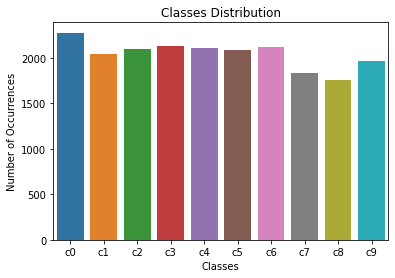

Total number of training data : 20405


In [ ]:
df_train = dataList[(dataList['subject'] != 'p012') & (dataList['subject'] != 'p026')]
print("Total number of training data :",len(df_train))
class_count  = df_train.groupby('classname').size()

sns.barplot(class_count.index, class_count.values)
plt.title('Classes Distribution')
plt.ylabel('Number of Occurrences')
plt.xlabel('Classes')
plt.show()
print("Total number of training data :",len(df_train))

In [ ]:
transform = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomRotation(10),
                                 transforms.ToTensor()])

**Splitting into train and validation datasets**

In [ ]:
data = datasets.ImageFolder(root = training_path, transform = transform)

In [ ]:
total_len = len(data)
training_len = int(0.9*total_len)
val_len = total_len - training_len

In [ ]:
training_data,val_data = torch.utils.data.random_split(data,(training_len,val_len))

**Checking GPU**

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


**Loading the train and validation data**

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=32,
                                           shuffle=True,
                                           drop_last=False,
                                           num_workers=2)
val_loader = torch.utils.data.DataLoader(dataset=val_data,
                                          batch_size=32,
                                          shuffle=False,
                                          drop_last=False,
                                          num_workers=2)

**Training the model**

In [ ]:
def model_training(model, criterion, optimizer, scheduler, n_epochs):
    
    training_losses = []
    train_accuracies = []
    val_accuracies = []
    model.train()
    for epoch in tqdm(range(n_epochs)):
        print("\nStarting epoch ", epoch+1)
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for data in train_loader:

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)

        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        training_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        model.eval()
        correct = 0
        val_labels = 0
        running_loss = 0
        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)
            
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
            
                val_labels += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = (correct / val_labels) * 100
        print('Validation Accuracy: %d %%' % (val_acc))
        val_accuracies.append(val_acc)
        
        torch.save(model.state_dict(), shared_filepath+'Models/model_resnet_epoch{}.pth'.format(epoch+1)) 
    
        model.train()
        scheduler.step(val_acc)
        since = time.time()
    print('Complete')
    return model, training_losses, train_accuracies, val_accuracies

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 10) #No. of classes = 10
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
num_e=10 ##number of epochs

model_ft, training_losses, training_accs, val_accs = model_training(model_ft, criterion, optimizer, lrscheduler, num_e)

  0%|          | 0/10 [00:00<?, ?it/s]


Starting epoch  1
Epoch 1, duration: 2580 s, loss: 0.2307, acc: 92.4543
Validation Accuracy: 97 %


 10%|█         | 1/10 [47:46<7:10:00, 2866.77s/it]


Starting epoch  2
Epoch 2, duration: 305 s, loss: 0.0315, acc: 99.1126
Validation Accuracy: 98 %


 20%|██        | 2/10 [53:20<3:03:32, 1376.62s/it]


Starting epoch  3
Epoch 3, duration: 305 s, loss: 0.0121, acc: 99.6679
Validation Accuracy: 99 %


 30%|███       | 3/10 [58:53<1:44:59, 899.99s/it] 


Starting epoch  4
Epoch 4, duration: 305 s, loss: 0.0069, acc: 99.7822
Validation Accuracy: 99 %


 40%|████      | 4/10 [1:04:24<1:07:33, 675.60s/it]


Starting epoch  5
Epoch 5, duration: 306 s, loss: 0.0029, acc: 99.9238
Validation Accuracy: 99 %


 50%|█████     | 5/10 [1:09:54<45:54, 550.84s/it]  


Starting epoch  6
Epoch 6, duration: 306 s, loss: 0.0010, acc: 99.9510
Validation Accuracy: 99 %


 60%|██████    | 6/10 [1:15:24<31:43, 475.76s/it]


Starting epoch  7
Epoch 7, duration: 306 s, loss: 0.0006, acc: 99.9728
Validation Accuracy: 99 %


 70%|███████   | 7/10 [1:20:54<21:24, 428.17s/it]


Starting epoch  8
Epoch 8, duration: 307 s, loss: 0.0009, acc: 99.9564
Validation Accuracy: 99 %


 80%|████████  | 8/10 [1:26:24<13:13, 396.97s/it]


Starting epoch  9
Epoch 9, duration: 306 s, loss: 0.0005, acc: 99.9782
Validation Accuracy: 99 %


 90%|█████████ | 9/10 [1:31:54<06:16, 376.10s/it]


Starting epoch  10
Epoch 10, duration: 307 s, loss: 0.0005, acc: 99.9728
Validation Accuracy: 99 %


100%|██████████| 10/10 [1:37:25<00:00, 584.52s/it]

Complete


In [ ]:
training_accs

[92.45426829268293,
 99.11258710801394,
 99.66790069686411,
 99.78222996515679,
 99.92378048780488,
 99.95100174216027,
 99.9727787456446,
 99.95644599303135,
 99.97822299651568,
 99.9727787456446]

In [8]:
val_accs

[98.23615874571288,
 99.4610485056345,
 99.70602645761882,
 99.80401763841255,
 99.75502204801568,
 99.80401763841255,
 99.70602645761882,
 99.65703086722195,
 99.75502204801568,
 99.80401763841255]

**Plotting training vs validation accuracy**

<Figure size 432x288 with 0 Axes>

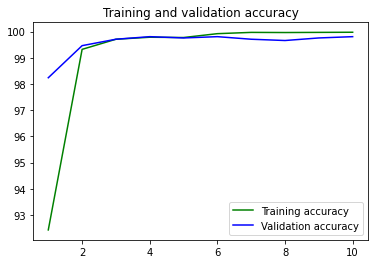

<Figure size 432x288 with 0 Axes>

In [7]:
plt.plot(range(1,num_e+1), training_accs, 'g', label='Training accuracy')
plt.plot(range(1,num_e+1), val_accs, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

**Testing**

In [ ]:
model_test = models.resnet50()
num_ftrs = model_test.fc.in_features
model_test.fc = nn.Linear(num_ftrs, 10)
##load the model which we chose where there was no overfitting
model_test.load_state_dict(torch.load(shared_filepath+"Models/model_resnet_epoch5.pth"))
model_test.eval()
model_test.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
testing_path = shared_filepath+"TestData"

In [ ]:
def test_model(test_data,model_test):
    ground_truth = []
    pred_y = []
    with torch.no_grad():
        for x,y in tqdm(test_data):
            x = x.to(device)
            pred = torch.argmax(model_test(x),dim=1)
            ground_truth.extend(list(np.array(y)))
            pred_y.extend(list(np.array(pred.cpu())))
    return ground_truth,pred_y

In [ ]:
testing_data = datasets.ImageFolder(root = testing_path, transform = transform)

total_test_len = len(testing_data)

In [ ]:
testing_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                           batch_size=32,
                                           shuffle=True,
                                           drop_last=False,
                                           num_workers=2)

In [ ]:
ground_truth,pred_y = test_model(testing_loader,model_test)

100%|██████████| 64/64 [05:09<00:00,  4.84s/it]


**Performance metrics**

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(ground_truth, pred_y)

0.9157999009410599

In [ ]:
precision = precision_score(ground_truth,pred_y,average='micro')
print('Precision: ', precision)

Precision:  0.9157999009410599


In [ ]:
f1 = f1_score(ground_truth,pred_y,average='micro')
print('F1 score: ', f1)

F1 score:  0.9157999009410598


In [ ]:
recallscore = recall_score(ground_truth,pred_y,average='micro')
print('Recall score: ', recallscore)

Recall score:  0.9157999009410599


**Top 2 accuracy**

In [ ]:
def topk_pred(test_data,model,k):
    y_true = []
    y_pred = []
    n = len(test_data)
    sum = 0
    with torch.no_grad():
        for x,y in tqdm(test_data):
            x = x.to(device)
            pred = torch.topk(model(x), k).indices
            y_true.extend(list(np.array(y)))
            y_pred.extend(list(np.array(pred.cpu())))
    positivecount = 0
    for i in range(len(y_true)):
      if y_true[i] in y_pred[i]:
        positivecount += 1

    return positivecount/len(y_true)

In [ ]:
top2_acc = topk_pred(testing_loader,model_test,2)

100%|██████████| 64/64 [00:24<00:00,  2.65it/s]


In [ ]:
top2_acc

0.9732540861812778

In [ ]:
from sklearn.metrics import classification_report
final_repo = classification_report(ground_truth, pred_y, zero_division=1,target_names = list(class_dict.values()))
print(final_repo)

                              precision    recall  f1-score   support

                safe driving       0.69      0.75      0.72       214
             texting - right       1.00      1.00      1.00       224
talking on the phone - right       1.00      1.00      1.00       221
              texting - left       0.99      0.98      0.98       220
 talking on the phone - left       0.91      0.98      0.94       223
         operating the radio       0.97      1.00      0.98       226
                    drinking       0.98      0.98      0.98       203
             reaching behind       0.99      1.00      1.00       169
             hair and makeup       0.95      0.81      0.87       159
        talking to passenger       0.63      0.55      0.59       160

                    accuracy                           0.92      2019
                   macro avg       0.91      0.90      0.91      2019
                weighted avg       0.92      0.92      0.91      2019



**Confusion Matrix**

In [ ]:
confusionMatrix = confusion_matrix(ground_truth,pred_y)

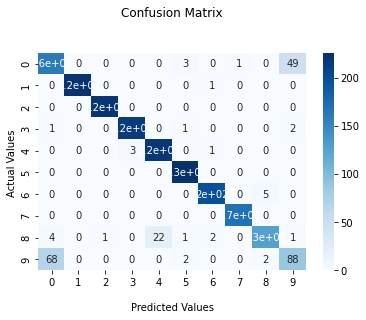

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

ax = sns.heatmap(confusionMatrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

**Displaying images with predictions and ground truth**

In [ ]:
files = np.random.choice(dataList[dataList['subject'].isin(['p012','p026'])]['img'].tolist(),9)

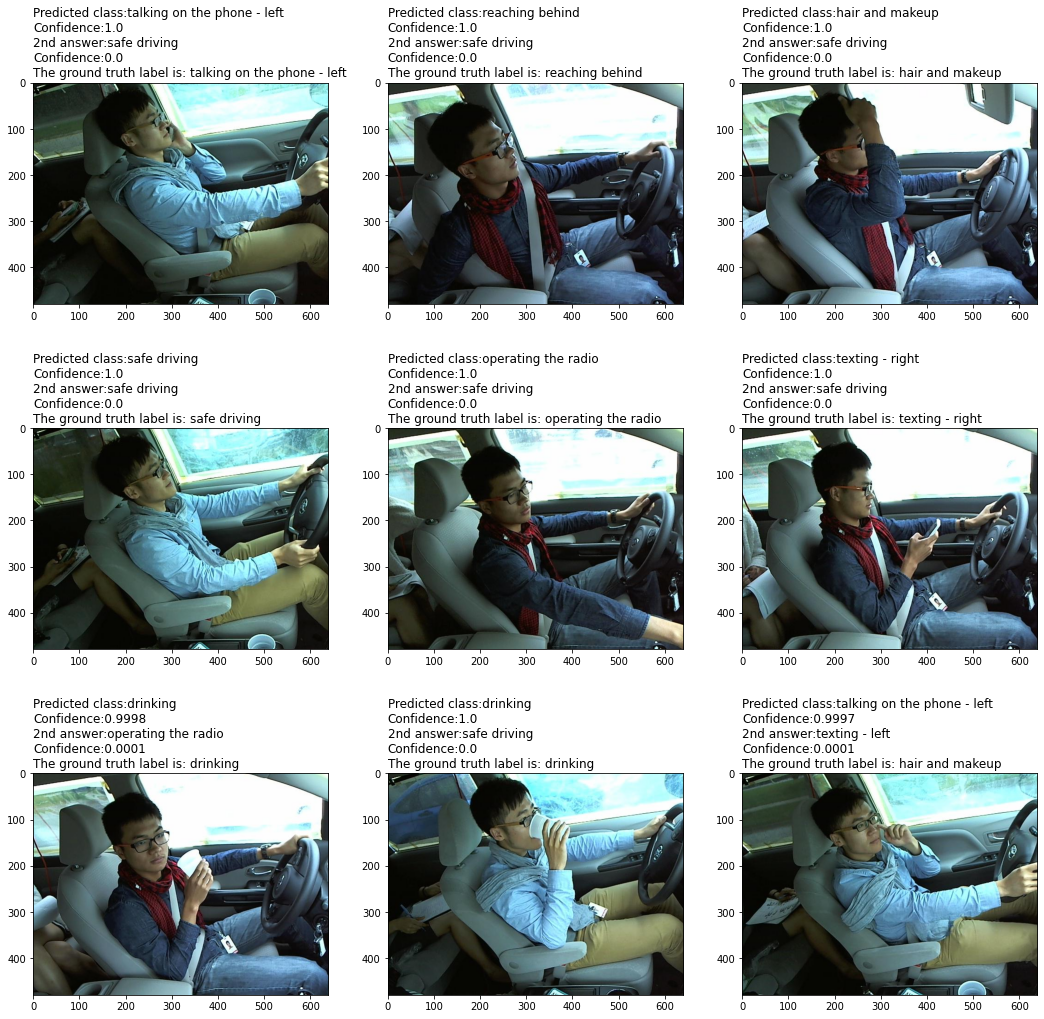

In [ ]:
from pandas.io.parsers.readers import TextFileReader
plt.figure(figsize=(18,18))
text_list = []

for i in range(len(files)):
    plt.subplot(3,3,i+1)   
    img = cv2.imread(glob(shared_filepath+'TestData/*/'+files[i])[0])
    img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_cvt)
    with PIL.Image.open(glob(shared_filepath+'TestData/*/'+files[i])[0]) as im:
      im = transform(im)
      im = im.unsqueeze(0)
      output = model_test(im.cuda())
      proba = nn.Softmax(dim=1)(output)
      proba = [round(float(elem),4) for elem in proba[0]]
      proba2 = proba.copy()
      proba2[proba2.index(max(proba2))] = 0.
      text  = "Predicted class:"+class_dict[proba.index(max(proba))]+"\n"+"Confidence:"+str(max(proba))+"\n"+"2nd answer:"+class_dict[proba2.index(max(proba2))]+"\n"+"Confidence:"+str(max(proba2))+"\n"+"The ground truth label is: "+class_dict[int(dataList[dataList['img'] == files[i]]["classname"].iloc[0][1:])]
      text_list.append(text)
      

    plt.title(text, loc='left')



plt.show()

**GradCAM**

In [ ]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.1 MB 8.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.2-py3-none-any.whl size=32305 sha256=c2d1a123281d36004d5dbb5e88a5752e1ea2b4efee12eadb0654b4f78a69ad5c
  Stored in directory: /root/.cache/pip/wheels/a0/9c/d6/980994b42f520eade90b6d5c7e2613dad62d50d2497820d208
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch

from torchvision import transforms
from glob import glob
from PIL import Image

def gradcammap(model_test,file):

  target_layers = [model_test.layer4[-1]]
  convert_tensor = transforms.ToTensor()
  img = Image.open(glob(shared_filepath+'TestData/*/'+file)[0])
  input_tensor = convert_tensor(img).unsqueeze(0)

  cam = GradCAM(model=model_test, target_layers=target_layers, use_cuda=device)
  grayscale_cam = cam(input_tensor=input_tensor)

  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(np.asarray(img,dtype="float32")/255, grayscale_cam, use_rgb=True)
  return visualization

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image


In [ ]:
img_vis_lst = []
for file in files:
  img_vis_lst.append(gradcammap(model_test,file))

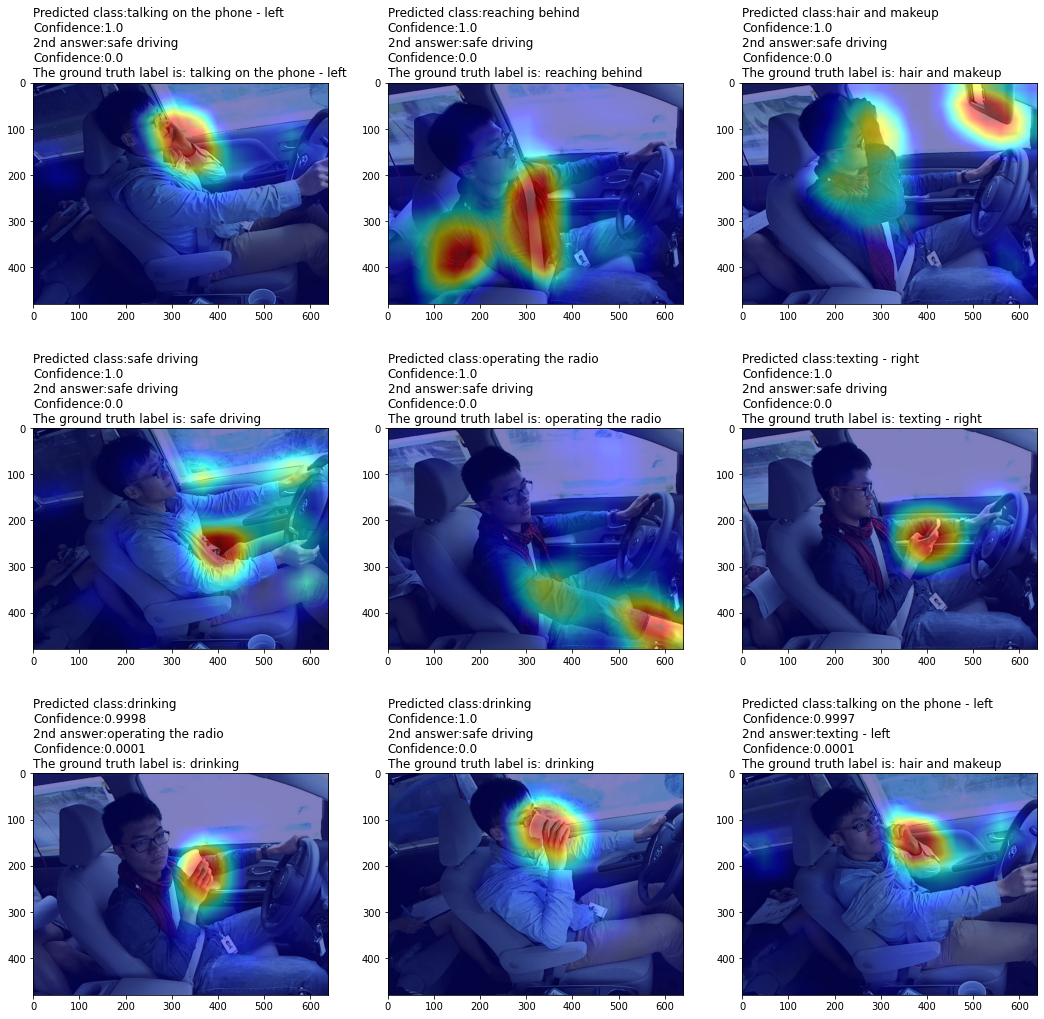

In [ ]:
plt.figure(figsize=(18,18))

for i in range(len(img_vis_lst)):
    plt.subplot(3,3,i+1)   
    plt.imshow(img_vis_lst[i])
    plt.title(text_list[i], loc='left')

**New test data**

In [ ]:
testdata2 = datasets.ImageFolder(root = shared_filepath+"TestData2", transform = transform)
test_loader2 = torch.utils.data.DataLoader(dataset=testdata2,
                                           batch_size=32,
                                           shuffle=True,
                                           drop_last=False,
                                           num_workers=2)

In [ ]:
true_labels_2,pred_label_2 = test_model(test_loader2,model_test)

100%|██████████| 1/1 [00:09<00:00,  9.38s/it]


In [ ]:
file_2 = ['C2DA7D06-1BCE-414A-B7DA-6C1915DDB343_1_105_c.jpeg', '95AE8FD7-09B1-4586-BB5D-EB68C3B48141_1_105_c.jpeg', 'c5_1.jpg', '4B9BC178-BA7B-4221-B9F9-7C03333D3269_1_105_c.jpeg','c0_1.jpg',  '042E664B-B3BE-4760-B9F1-AE872CB6779F_1_105_c.jpeg', 'F96E114F-19E7-4ECF-AE08-8FFF25EAACCA_1_105_c.jpeg']

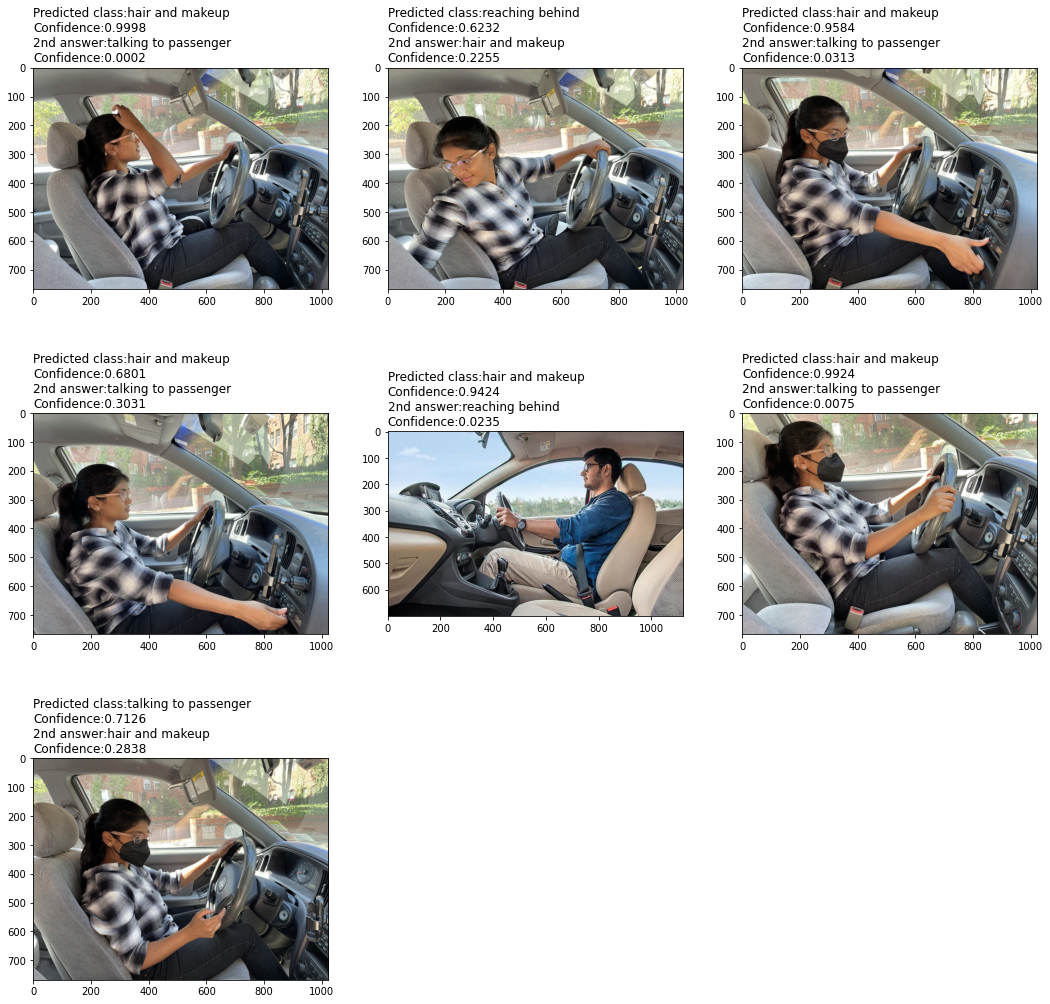

In [ ]:
from pandas.io.parsers.readers import TextFileReader
plt.figure(figsize=(18,18))
text_list = []

for i in range(len(file_2)):
    plt.subplot(3,3,i+1)   
    img = cv2.imread(glob(shared_filepath+'TestData2/*/'+file_2[i])[0])
    img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_cvt)
    with PIL.Image.open(glob(shared_filepath+'TestData2/*/'+file_2[i])[0]) as im:
      im = transform(im)
      im = im.unsqueeze(0)
      output = model_test(im.cuda())
      proba = nn.Softmax(dim=1)(output)
      proba = [round(float(elem),4) for elem in proba[0]]
      proba2 = proba.copy()
      proba2[proba2.index(max(proba2))] = 0.
      text  = "Predicted class:"+class_dict[proba.index(max(proba))]+"\n"+"Confidence:"+str(max(proba))+"\n"+"2nd answer:"+class_dict[proba2.index(max(proba2))]+"\n"+"Confidence:"+str(max(proba2))
      text_list.append(text)
      

    plt.title(text, loc='left')



plt.show()

**GradCam for new data**

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch

from torchvision import transforms

from PIL import Image

def gradcammap2(modelloaded,file):
  target_layers = [modelloaded.layer4[-1]]
  convert_tensor = transforms.ToTensor()
  img = Image.open(glob(shared_filepath+'TestData2/*/'+file)[0])

  input_tensor = convert_tensor(img).unsqueeze(0)

  cam = GradCAM(model=modelloaded, target_layers=target_layers, use_cuda=device)

  grayscale_cam = cam(input_tensor=input_tensor)

  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(np.asarray(img,dtype="float32")/255, grayscale_cam, use_rgb=True)
  return visualization

In [ ]:
img_vis_lst_2 = []
for file in file_2:
  img_vis_lst_2.append(gradcammap2(model_test,file))

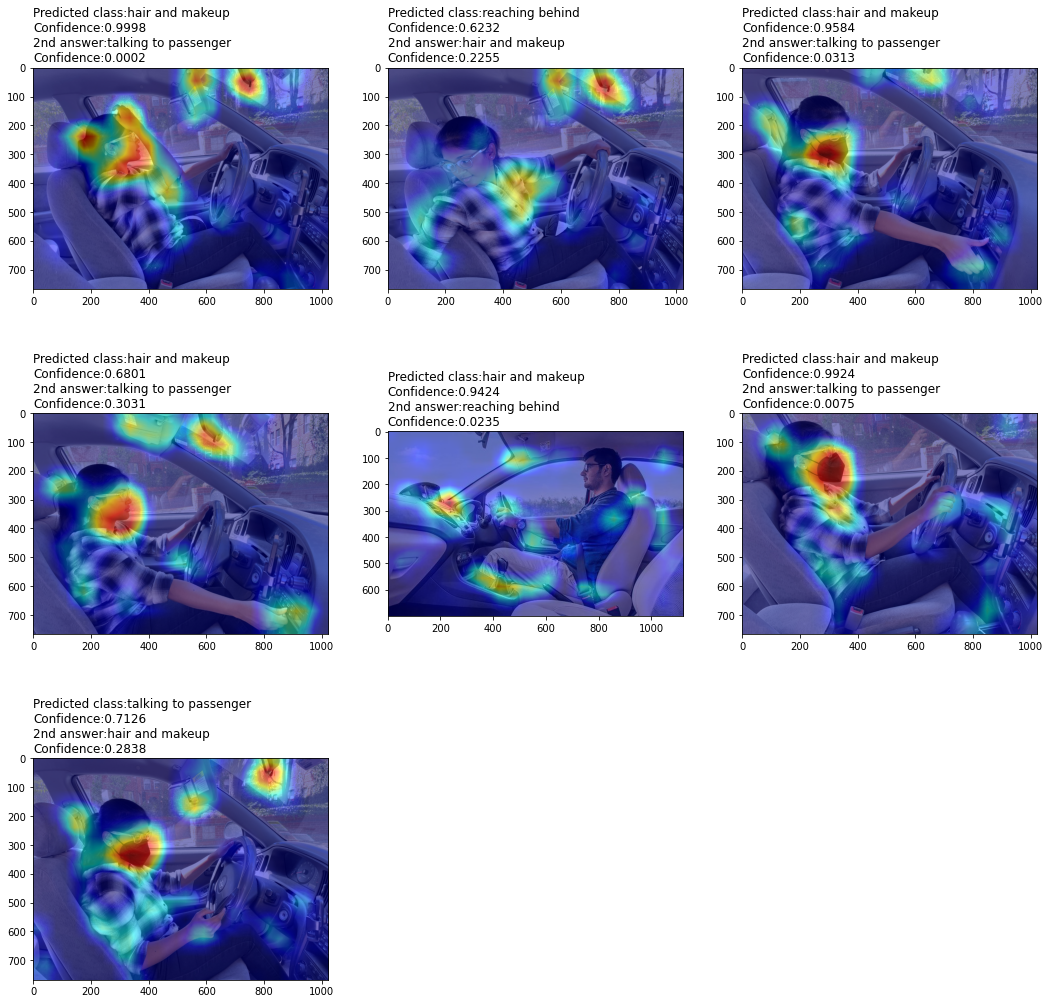

In [ ]:
plt.figure(figsize=(18,18))

for i in range(len(img_vis_lst_2)):
    plt.subplot(3,3,i+1)   
    plt.imshow(img_vis_lst_2[i])
    plt.title(text_list[i], loc='left')